In [1]:
import datajoint as dj
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

%matplotlib inline

In [2]:
from numpy.linalg import inv

In [3]:
cd_dataset = dj.create_virtual_module('cd_dataset', 'edgar_cd_dataset')

class_discrimination = dj.create_virtual_module('class_discrimination', 'edgar_class_discrimination')

# Get all sessions for `subject_id=21` (Tom)

sessions = (class_discrimination.SpikeCountSet()).fetch(dj.key)

# Select a single session

key = sessions[4]

# Get the data

all_data = (class_discrimination.ClassDiscriminationTrial() * class_discrimination.SpikeCountTrials() & class_discrimination.CleanSpikeCountTrials() & key).fetch()

Connecting eywalker@10.28.3.113:3306


/usr/local/lib/python3.5/dist-packages/pymysql/cursors.py:166: Warning: (1681, "'ERROR_FOR_DIVISION_BY_ZERO' is deprecated and will be removed in a future release.")
  result = self._query(query)
/usr/local/lib/python3.5/dist-packages/pymysql/cursors.py:166: Warning: (1681, "'NO_ZERO_DATE' is deprecated and will be removed in a future release.")
  result = self._query(query)
/usr/local/lib/python3.5/dist-packages/pymysql/cursors.py:166: Warning: (1681, "'NO_ZERO_IN_DATE' is deprecated and will be removed in a future release.")
  result = self._query(query)


In [4]:
# Select out contrast

np.unique(all_data['contrast'])

array([ 0.01,  0.1 ,  0.9 ])

In [5]:
contrast = 0.9
f = all_data['contrast'] == contrast

data = all_data[f]

Prepare the data

In [6]:
counts = np.concatenate(data['counts'], 1).T
ori = data['orientation']

nbins = 61
delta = 1
p = np.round((ori - 270)/ delta) + (nbins//2)


sigmaA = 3
sigmaB = 15



pos = (p >= 0) & (p < nbins)

p = p[pos]
counts = counts[pos]

# split into train and validation set
fraction = 0.8
N = len(counts)
pos = np.arange(N)
split = round(N * fraction)
np.random.shuffle(pos)
train_pos = pos[:split]
valid_pos = pos[split:]

train_counts = counts[train_pos]
train_ori = p[train_pos]

valid_counts = counts[valid_pos]
valid_ori = p[valid_pos]

pv = (np.arange(nbins) - nbins//2) * delta
prior = np.log(np.exp(- pv**2 / 2 / sigmaA**2) / sigmaA + np.exp(- pv**2 / 2 / sigmaB**2) / sigmaB)
prior = Variable(torch.from_numpy(prior)).cuda().float()

In [7]:
class Net(nn.Module):
    def __init__(self, n_channel=96, n_hidden=100, n_output=nbins, dropout=0.9, std=0.01):
        super().__init__()
        self.n_channel = n_channel
        self.std = std
        self.n_output = n_output
        self.dropout = dropout
        
        if not isinstance(n_hidden, (list, tuple)):
            n_hidden = (n_hidden,)
        
        self.n_hidden = n_hidden
        
        n_prev = n_channel
        
        hiddens = []
        
        for n in n_hidden:
            hiddens.append(nn.Linear(n_prev, n))
            hiddens.append(nn.ReLU())
            if dropout > 0.0:
                hiddens.append(nn.Dropout(p=dropout, inplace=True))
            n_prev = n
        if len(hiddens) > 0:
            self.hiddens = nn.Sequential(*hiddens)
        else:
            self.hiddens = lambda x: x
        self.ro_layer = nn.Linear(n_prev, n_output)
        
        self.initialize()
        
        
    def forward(self, x):
        x = self.hiddens(x)
        x = self.ro_layer(x)
        return x
    
    def initialize(self):
        def fn(mod):
            if isinstance(mod, nn.Linear):
                normal(mod.weight, std=self.std)
                constant(mod.bias, 0)
        self.apply(fn)

In [8]:
train_x = torch.Tensor(train_counts)
train_t = torch.Tensor(train_ori).type(torch.LongTensor)

valid_x = Variable(torch.Tensor(valid_counts)).cuda()
valid_t = Variable(torch.Tensor(valid_ori).type(torch.LongTensor)).cuda()

train_dataset = TensorDataset(train_x, train_t)
valid_dataset = TensorDataset(valid_x, valid_t)

In [9]:
def objective(net, x=None, t=None):
    if x is None and t is None:
        x = valid_x
        t = valid_t
    net.eval()
    y = net(x)
    posterior = y + prior
    _, loc = torch.max(posterior, dim=1)
    v =(t.double() - loc.double()).pow(2).mean().sqrt() * delta
    return v.data.cpu().numpy()[0]
    #return loss(valid_y, valid_t).data.cpu().numpy()[0]

## Try linear regression

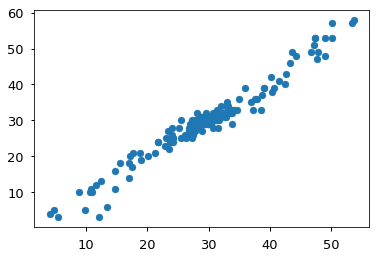

In [10]:
def extend_ones(x):
    return np.concatenate([x, np.ones([x.shape[0], 1])], axis=1)

tc = extend_ones(train_counts)

w = inv(tc.T @ tc + np.diag(np.ones(tc.shape[1]) * 0.0001)) @ tc.T @ train_ori

t_hat = extend_ones(valid_counts) @ w

plt.scatter(t_hat, valid_ori)

In [11]:
np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta

2.2969333057886159

## Fit NN

In [13]:
net = Net(n_output=61, n_hidden=[400, 400], std=0.0001, dropout=0.5)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()

1.61892403549


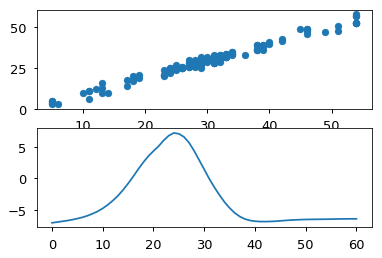

In [17]:
net.eval()
y = net(valid_x)

y = y + prior
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()

plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)

print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

In [16]:
net.std = 1e-3
net.initialize()

alpha = 30 #3e-2 #7e-3 #1e-3


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)
learning_rates = 0.03 * 3.0**(-np.arange(3))

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch, valid_score in early_stopping(net, objective, interval=20, start=100, patience=20, max_iter=300000, maximize=False):
        data_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
        for x_, t_ in data_loader:
            x, t = Variable(x_).cuda(), Variable(t_).cuda()
            net.train()
            optimizer.zero_grad()
            y = net(x)
            post = y + prior
            val, _ = post.max(1, keepdim=True)
            post = post - val
            #sparcity = y.abs().sum(1).mean()
            conv_filter = Variable(torch.from_numpy(np.array([-0.25, 0.5, -0.25])[None, None, :]).type(y.data.type()))
            smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()
            score = loss(post, t)
            score = score + alpha * smoothness
            score.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('Score: {}'.format(score.data.cpu().numpy()[0]))
        #scheduler.step()





 LEARNING RATE: 0.03
Score: 3.5714612007141113
Score: 3.47995662689209
[120|01/20] -/-> 10.55393864464981
Score: 3.425583839416504
Score: 3.64201021194458
[140|02/20] -/-> 10.56786348142762
Score: 3.503016948699951
Score: 3.410142660140991
[160|03/20] -/-> 10.56786348142762
Score: 3.572094678878784
Score: 3.644246816635132
[180|04/20] -/-> 10.56786348142762
Score: 3.4724009037017822
Score: 3.3904471397399902
[200|05/20] -/-> 10.56786348142762
Score: 3.5141611099243164
Score: 3.5607571601867676
[220|05/20] ---> 9.46924847422786
Score: 3.3798811435699463
Score: 3.4440646171569824
[240|00/20] ---> 8.376749646522981
Score: 3.4750659465789795
Score: 3.4539082050323486
[260|01/20] -/-> 9.170498307926689
Score: 3.186400890350342
Score: 3.311811923980713
[280|02/20] -/-> 10.56786348142762
Score: 3.4482998847961426
Score: 3.3725101947784424
[300|03/20] -/-> 9.931464490602812
Score: 3.3977608680725098
Score: 3.2050390243530273
[320|04/20] -/-> 9.083490734380073
Score: 3.4852616786956787
Scor

Score: 1.755223035812378
Score: 1.8336355686187744
[1460|18/20] -/-> 2.0097800094225513
Score: 1.8678821325302124
Score: 1.8039146661758423
[1480|19/20] -/-> 1.8873503922875512
Score: 1.739498496055603
Score: 1.9359065294265747
[1500|20/20] -/-> 1.8594397919452195
Restoring best model! 1.859440 ---> 1.743335




 LEARNING RATE: 0.003333333333333333
Score: 1.849125862121582
Score: 1.7632719278335571
[120|00/20] ---> 1.6919648631219313
Score: 1.7845591306686401
Score: 1.752947449684143
[140|00/20] ---> 1.6725386754616565
Score: 1.8079349994659424
Score: 1.7728862762451172
[160|01/20] -/-> 1.7395814987662042
Score: 1.7494782209396362
Score: 1.7104594707489014
[180|02/20] -/-> 1.7111705277859943
Score: 1.8180328607559204
Score: 1.8291324377059937
[200|02/20] ---> 1.6189240354876873
Score: 1.7275816202163696
Score: 1.742167353630066
[220|01/20] -/-> 1.7111705277859943
Score: 1.870180368423462
Score: 1.7668085098266602
[240|02/20] -/-> 1.6803361008336117
Score: 1.8217970132827759
Score: 1.81

In [20]:
objective(net, Variable(train_x).cuda(), Variable(train_t).cuda())

1.1003564484863484

In [22]:
objective(net, valid_x, valid_t)

1.6189240354876873

In [26]:
np.isnan(avg_sigma)

False

Text(0.5,0.98,'Contrast=90.0%  $\\mathbf{E}[\\sigma]$=2.188')

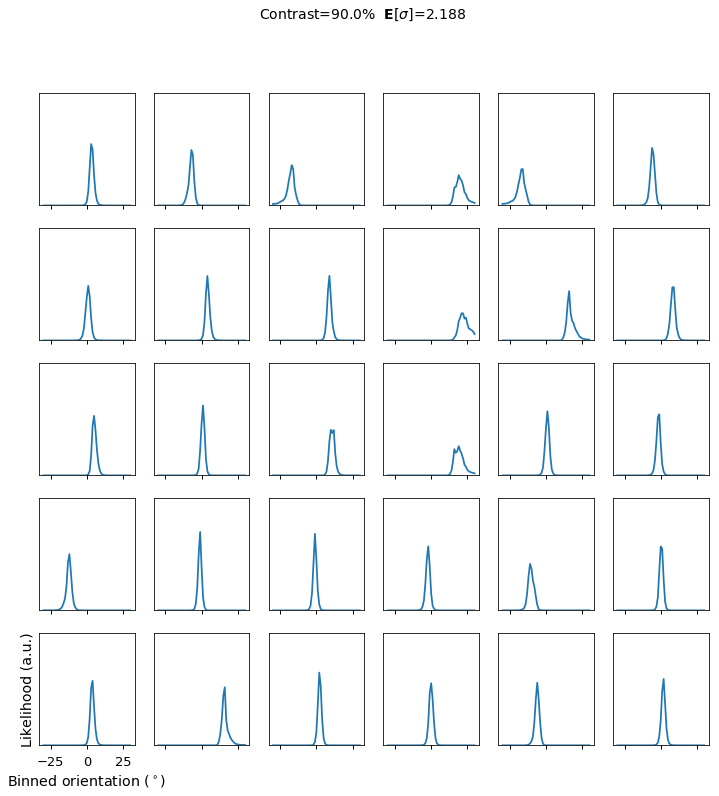

In [24]:
from itertools import count

y = net(valid_x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta


n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    
    ax.plot(pv, yd[c])
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Binned orientation ($^\circ$)')
    else:
        ax.set_xticklabels([])

fig.suptitle("Contrast={:0.1f}%  $\mathbf{{E}}[\sigma]$={:0.3f}".format(contrast*100, avg_sigma), fontsize=14)


In [ ]:
net.s

Text(0.5,0.98,'Contrast=2.0%  $\\mathbf{E}[\\sigma]$=7.214')

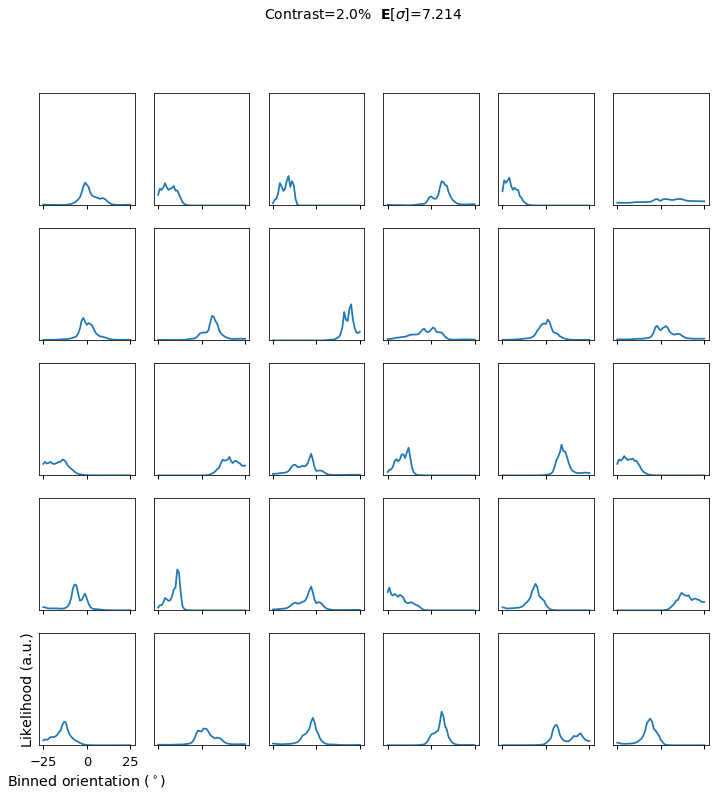

In [735]:
from itertools import count

y = net(valid_x)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta


n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    
    ax.plot(pv, yd[c])
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Binned orientation ($^\circ$)')
    else:
        ax.set_xticklabels([])

fig.suptitle("Contrast={:0.1f}%  $\mathbf{{E}}[\sigma]$={:0.3f}".format(contrast*100, avg_sigma), fontsize=14)


In [ ]:
np.nditer()

## Measure std of likelihood functions

In [476]:
loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

np.mean(np.sqrt(np.sum(yd * ds, axis=1)))

2.2917690092396952

In [451]:
loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

np.mean(np.sqrt(np.sum(yd * ds, axis=1)))

5.0262529479766958

In [391]:
loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

np.mean(np.sqrt(np.sum(yd * ds, axis=1)))

15.074714201873206

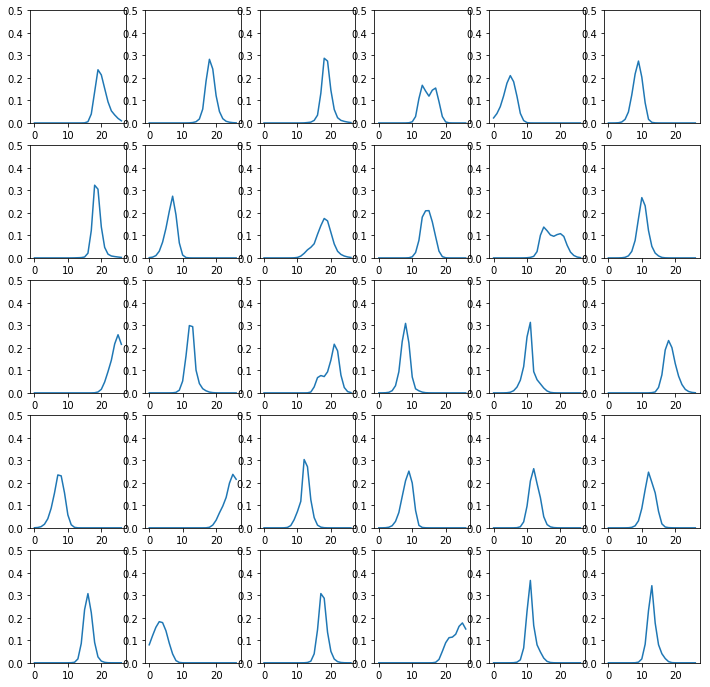

In [44]:
from itertools import count

y = net(valid_x)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

fig, axs = plt.subplots(5, 6, figsize=(12, 12))
for i, ax in zip(count(), axs.ravel()):
    ax.plot(yd[i])
    ax.set_ylim([0, 0.5])

In [ ]:
data = fetch(class_discrimination.ClassDiscriminationTrial * class_discrimination.SpikeCountTrials * class_discrimination.CSCLookup  & class_discrimination.CleanSpikeCountTrials & self, '*');
            data = dj.struct.sort(data, 'trial_num');
            contrast = fetchn(self, 'dataset_contrast');
            all_contrast = arrayfun(@num2str, [data.contrast], 'UniformOutput', false);
            pos = strcmp(all_contrast, contrast);
            dataSet = data(pos);
            if pack
                dataSet = packData(dataSet);
            end